In [246]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import torch
import pandas as pd

In [2]:
import os
os.chdir("D://datasets/sc2 matches")

In [3]:
dataset = pd.read_csv("sc2-matches-history.csv")

# Some cleaning, dealing with null values and unusual cases

In [4]:
#Here we note only one missing value
dataset.isnull().sum(axis = 0)

match_date               0
player_1                 0
player_1_match_status    0
score                    0
player_2                 1
player_2_match_status    0
player_1_race            0
player_2_race            0
addon                    0
tournament_type          0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
dataset['player_1_win'] = (dataset['player_1_match_status'] == '[winner]') * 1
dataset.head()

,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type,player_1_win
0,09/19/2016,MC,[loser],0–2,Stats,[winner],P,P,LotV,online,0
1,09/19/2016,MC,[winner],2–1,NaTuRal,[loser],P,T,LotV,online,1
2,09/19/2016,MC,[loser],1–2,Dark,[winner],P,Z,LotV,online,0
3,09/13/2016,MC,[loser],0–2,INnoVation,[winner],P,T,LotV,online,0
4,08/27/2016,MC,[loser],0–1,TRUE,[winner],P,Z,LotV,online,0


In [7]:
#We create a list, 'all_players' containing every category/player, so that we can encode every player, from both columns
dataset['player1'] = dataset['player_1'].astype('category')
dataset['player2'] = dataset['player_2'].astype('category')
all_players = list(set(list(dataset['player1'].values) + list(dataset['player2'].values)))

In [8]:
dataset['player1'] = dataset['player1'].cat.set_categories(all_players)
dataset['player2'] = dataset['player2'].cat.set_categories(all_players)

dataset['p1_codes'] = dataset['player1'].cat.codes
dataset['p2_codes'] = dataset['player2'].cat.codes

In [9]:
dataset['player_1_match_status'] = dataset['player_1_match_status'] == '[winner]'
dataset['player_2_match_status'] = dataset['player_2_match_status'] == '[winner]'

dataset.head()

,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type,player_1_win,player1,player2,p1_codes,p2_codes
0,09/19/2016,MC,False,0–2,Stats,True,P,P,LotV,online,0,MC,Stats,7378,6530
1,09/19/2016,MC,True,2–1,NaTuRal,False,P,T,LotV,online,1,MC,NaTuRal,7378,5918
2,09/19/2016,MC,False,1–2,Dark,True,P,Z,LotV,online,0,MC,Dark,7378,9947
3,09/13/2016,MC,False,0–2,INnoVation,True,P,T,LotV,online,0,MC,INnoVation,7378,9259
4,08/27/2016,MC,False,0–1,TRUE,True,P,Z,LotV,online,0,MC,TRUE,7378,8130


In [10]:
#for simplicity, we'll drop all ties and work with games with one winner and one loser
#these unusual matches make up a very small percent of all the data --- less than 1%
dataset = dataset.drop(dataset[((dataset.player_2_match_status == (1-dataset.player_1_match_status)) == False)].index)

In [11]:
#consider, that we can form a columns of who won
print(dataset['player_1_win'] * dataset['p1_codes'].astype('Int64'))

p1win = dataset['player_1_win']*dataset['p1_codes'].astype('Int64')
p2win = (1-dataset['player_1_win'])*dataset['p2_codes'].astype('Int64')
p1lose = (1-dataset['player_1_win'])*dataset['p1_codes'].astype('Int64')
p2lose = dataset['player_1_win']*dataset['p2_codes'].astype('Int64')

0            0
1         7378
2            0
3            0
4            0
          ... 
374789       0
374790    1935
374791       0
374792    1935
374793       0
Length: 373773, dtype: Int64


In [12]:
#training_df has rows representing matches, with the 1st entry in the row being the winner's code/ID
#the codes being used 

training_df = pd.DataFrame()
training_df['winner'] = p1win + p2win
training_df['loser'] = p1lose + p2lose
training_df.head()

,winner,loser
0,6530,7378
1,7378,5918
2,9947,7378
3,9259,7378
4,8130,7378


In [30]:
np_dataset = training_df.to_numpy().astype('int64')
np_players = np.asarray(all_players).reshape((10806,1))

In [31]:
torch_train = torch.from_numpy(np_dataset).long()

# Building the Model
For this model, we assume every player has a true unobserved skill z. We assume a gaussian prior distribution, and that the likelihood that player A beats player B is given by $\frac{1}{1 + e^{z_A - z_B}}$ for player skills $z_A, z_B$ respectively.

In [83]:
#we'll use a GPU if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#various functions needed to compute

def factorized_log_gaussian(mu, logsig, xs):
    sigma = torch.exp(logsig)
    constant = -torch.log(2*np.pi*(sigma**2)) / 2
    exponentpart = -(((xs-mu)/sigma)**2)/2
    return torch.sum(constant + exponentpart, 1)

def log_prior(zs):
    return factorized_log_gaussian(torch.zeros(1).to(device), torch.zeros(1).to(device), zs)

def logp_a_beats_b(za, zb):
    # za and zb are (num_samples x 1)
    return -torch.log1p(torch.exp(zb - za))

def all_games_likelihood(matches, zs):
    # matches is an array of size (num_games x 2)
    # zs is an array of size (num_samples x num_players)
    
    zs_a = zs[:, matches[:, 0]]
    zs_b = zs[:, matches[:, 1]]
    likes = logp_a_beats_b(zs_a, zs_b)
    return torch.sum(likes, 1)

def joint_log_density(matches, zs):
    return all_games_likelihood(matches, zs) + log_prior(zs)

#We'll minimize KL-Divergence by maximizing ELBO (or minimizing negative ELGO)

def elbo(params, logp, num_samples):
    epsilon = torch.randn(num_samples,1).to(device)
    samples = params[0] + torch.exp(params[1])*epsilon
    
    
    logp_estimates = logp(samples)
    logq_estimates = factorized_log_gaussian(params[0], params[1], samples)
    return torch.sum(logp_estimates - logq_estimates) / num_samples

def neg_toy_elbo(parameters, games, num_samples = 100):
    return -elbo(parameters, lambda x: joint_log_density(games, x), num_samples)



ELBO is given by $E_{z\sim q_\phi}[log(x,z) - log[q_\phi(z|x)]]$. 
Computing ELBO requires generating samples.

In [90]:
def fit_variational_dist(init_params,
                         game_evidence, num_iters=200, lr = 1e-4, num_q_samples = 50):
    params_cur = init_params
    for i in range(num_iters):
        loss = neg_toy_elbo(params_cur, game_evidence, num_q_samples)
        loss.backward()
        
        with torch.no_grad():
            params_cur[0] -= lr * params_cur[0].grad
            params_cur[1] -= lr * params_cur[1].grad
        if i % 10 == 0:
            print(loss.item())
        params_cur[0].grad.zero_()
        params_cur[1].grad.zero_()
        
    return params_cur

In [104]:
#here we initialize 10806 different values of mean and logsigma for the 10806 different players
init_mu = torch.randn(10806, requires_grad = True, dtype = torch.float64, device = device)
init_logsigma = torch.randn(10806, requires_grad = True, dtype = torch.float64, device = device)
start_params = [init_mu, init_logsigma]

In [105]:
fitted_parameters = fit_variational_dist(start_params, torch_train, num_iters=2000)

471927.2563559864
372237.3926884659
344871.1632233481
327001.8947170185
309697.73851145915
284834.478938344
288104.84175714705
276061.45154807466
278044.91957035835
277795.5673881093
268745.67168381735
273152.27548696817
261957.2694798722
266727.5530112921
259849.18662353564
253997.917277397
259396.52882444352
247541.0204861933
248920.13047790033
251429.46564606935
252171.43897347202
244536.99582982901
246048.1105955453
245120.77682840626
244395.36668588035
243305.0280176592
242017.04956979677
242475.28692964252
241821.74803538955
238031.94189370674
236645.26208906472
239468.26358635016
235089.4062322271
236063.41528392886
233442.28892339536
234159.81008228436
235114.1228955637
235062.34360859738
232836.19022750374
233341.77231905863
232729.4370255413
232342.5465075177
231206.39862353448
234106.83941383788
228754.41803794788
231399.49439116433
230076.0211123434
230616.7750507589
232477.85833535716
231158.98567556764
229421.46135681574
229077.31291348216
225616.19433283148
226973.319091

# Results
We can plot player skills, and our uncertainty about their skill

In [199]:
player_means = fitted_parameters[0].tolist()
player_logsig = fitted_parameters[1].tolist()


mean_series = pd.Series(player_means)
logsig_series = pd.Series(player_logsig)

[10323, 379, 343, 7262, 9259]
[2614, 4048, 598, 3171, 2545]


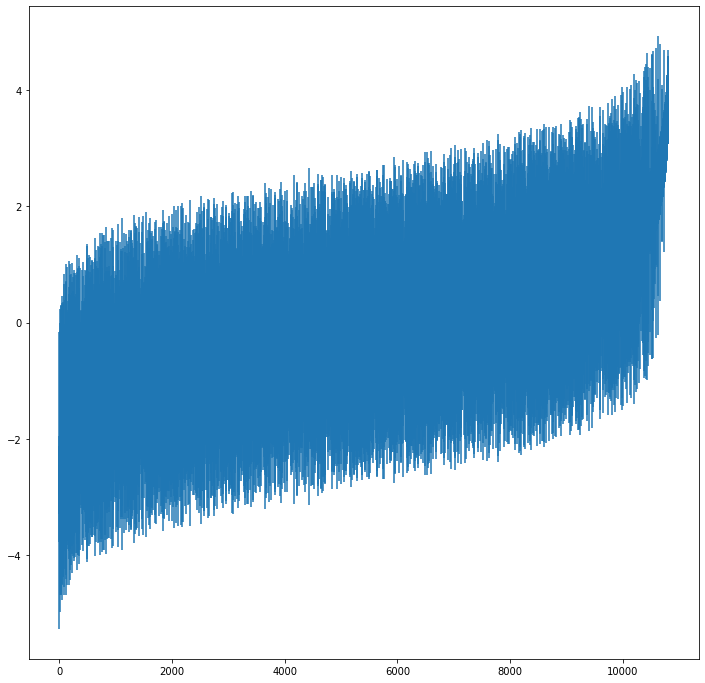

In [133]:
import matplotlib.pyplot as plt


sorted_players = sorted(range(10806), key=lambda k: player_means[k], reverse = False)

plot_x = range(10806)
plot_y = np.take(player_means, sorted_players)
y_error = (np.exp(np.take(player_logsig, sorted_players)))**2
y_error = y_error.tolist()


plt.figure(figsize=(12,12));
plt.errorbar(x=plot_x, y = plot_y, yerr = y_error);

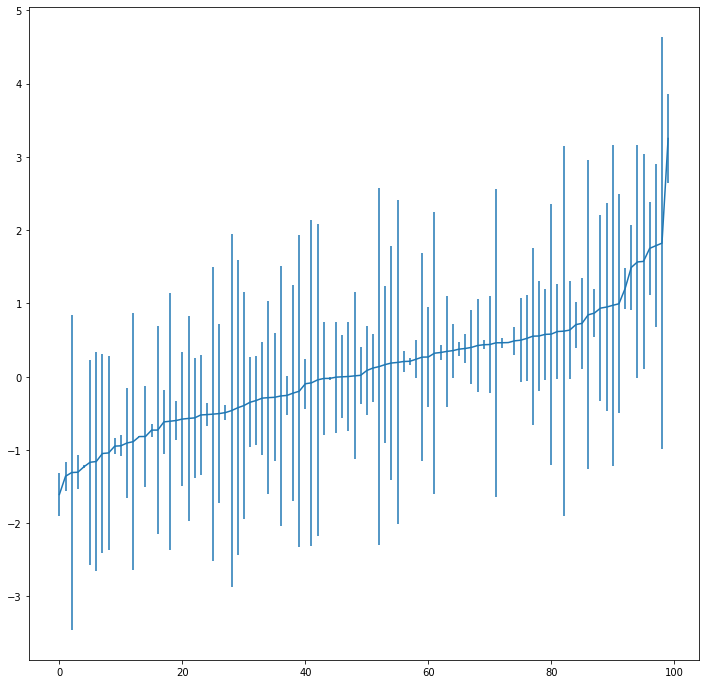

In [191]:
#Random sample of 100 players, out of the pool of 10806
#As the graph demonstrates, 

from random import sample

p_ind_asc = sorted(sample(range(10806), 100), key=lambda k: player_means[k], reverse = False)

plot_x = range(100)
plot_y = np.take(player_means, p_ind_asc)
y_error = (np.exp(np.take(player_logsig, p_ind_asc)))**2
y_error = y_error.tolist()

plt.figure(figsize=(12,12));
plt.errorbar(x=plot_x, y = plot_y, yerr = y_error);

# Outcomes, ranks

In [248]:
import seaborn as sns

In [153]:
print(sorted_players[-5:])
print(sorted_players[:5])

[10323, 379, 343, 7262, 9259]
[2614, 4048, 598, 3171, 2545]


In [155]:
print("The top 5 ranked players are: ")
print(np_players[sorted_players[-5:]])

print("\n")
print("The lowest 5 ranked players are: ")
print(np_players[sorted_players[:5]])

The top 5 ranked players are: 
[['PartinG']
 ['sOs']
 ['herO']
 ['ByuN']
 ['INnoVation']]


The lowest 5 ranked players are: 
[['Cuddles']
 ['THX']
 ['Ice']
 ['Terran']
 ['Slayer']]


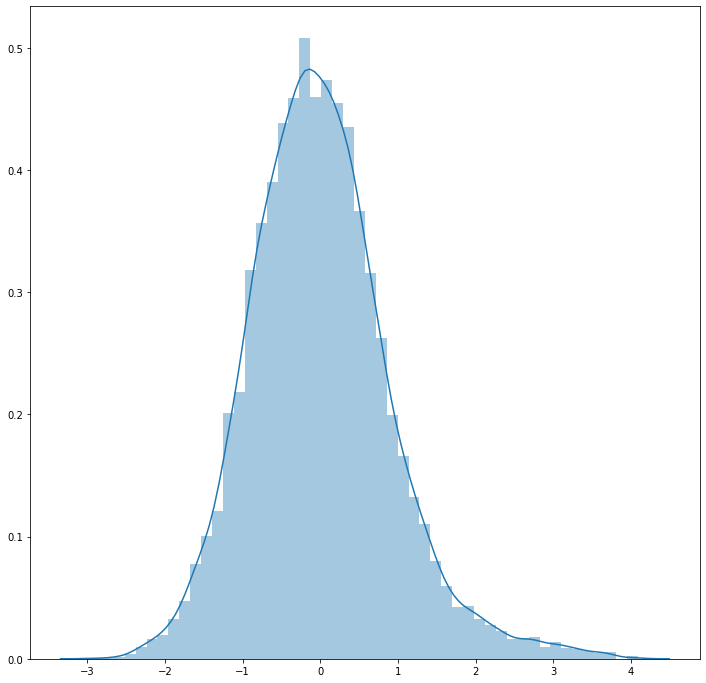

In [250]:
plt.figure(figsize=(12,12));
#plt.xlabel("Player Skill Rating")
#plt.ylabel("Frequency")
sns.distplot(player_means, bins=50);

From the above, the rating system believes that skill ratings are left skewed, and that there is a group of unusually good players, ie skill rating greater than 3.